In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale = 2.5)
import missingno as msno
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# 그래프에서 한글표현을 위해 폰트를 설치
%config InlineBackend.figure_format = 'retina'
!apt -qq -y install fonts-nanum > /dev/null

import matplotlib.font_manager as fm
font_file = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=font_file, size=9)

# 기본 글꼴 변경
import matplotlib as mpl
mpl.font_manager._rebuild()
mpl.pyplot.rc('font', family='NanumBarunGothic')

In [0]:
# 목표
- 2018.07.01. 00:00 ~ 24:00 시간당 전력사용량(24개)
- 2018.07.01. ~ 2018.07.10. 10일간 일간 전력사용량(10개)
- 2018.07.01. ~ 2018.11.30. 5개월간 월간 전력사용량(5개)

In [0]:
# 드라이브 마운트로 들어가는 경로
%ls-al '/content/drive/My Drive/11th_전력수요예측/'

total 74632
-r-------- 1 root root    17273 Sep 30 05:04 submission.csv
-r-------- 1 root root 12509368 Sep 30 05:04 test.csv
-r-------- 1 root root 63895280 Sep 30 05:05 train.csv


## 1. EDA

In [0]:
train = pd.read_csv('train.csv', index_col = 'Time', parse_dates = ['Time'])

In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16909 entries, 2016-07-26 11:00:00 to 2018-06-30 23:00:00
Columns: 1300 entries, X692 to X1163
dtypes: float64(1300)
memory usage: 167.8 MB


In [0]:
train.shape

(16909, 1300)

### Null data check

In [0]:
# 어마어마한 비율
train.isnull().sum().sum() / (16909 * 1300) * 100

77.20727241296169

In [0]:
train.columns

Index(['X692', 'X1272', 'X553', 'X1299', 'X4', 'X598', 'X1003', 'X1010',
       'X1216', 'X1047',
       ...
       'X1164', 'X656', 'X1287', 'X324', 'X767', 'X1271', 'X1288', 'X58',
       'X1033', 'X1163'],
      dtype='object', length=1300)

In [0]:
# 컬럼을 일단 정렬을 해놓자.
train1 = train.sort_index(axis = 1)
train1.head()

,X1,X100,X1000,X1001,X1002,X1003,X1004,X1005,X1006,X1007,X1008,X1009,X101,X1010,X1011,X1012,X1013,X1014,X1015,X1016,X1017,X1018,X1019,X1020,X1021,X1022,X1023,X1024,X1025,X1026,X1027,X1028,X1029,X103,X1030,X1031,X1032,X1033,X1034,X1035,...,X963,X964,X965,X966,X967,X968,X969,X97,X970,X971,X972,X973,X974,X975,X976,X977,X978,X979,X98,X980,X981,X982,X983,X984,X985,X986,X987,X988,X989,X99,X990,X991,X992,X993,X994,X995,X996,X997,X998,X999
Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-07-26 11:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.511,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-26 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-26 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.328,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-26 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-26 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.036,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
# 위의 방법으로 힘드니 column에서 X를 다 지워보자
train_c = train.columns
X_cut = [int(i.replace('X', '')) for i in train_c]

In [0]:
# 다시 정렬해보자
train.columns = X_cut
train = train.sort_index(axis = 1)

In [0]:
train.head()

,1,2,3,4,6,8,9,11,12,13,14,15,17,19,21,22,23,24,25,27,28,29,33,34,36,38,39,40,45,46,48,49,52,53,54,56,57,58,60,63,...,1461,1462,1463,1464,1465,1466,1467,1468,1469,1470,1471,1472,1473,1474,1475,1476,1477,1478,1479,1480,1481,1482,1483,1484,1485,1486,1487,1488,1489,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499,1500
Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-07-26 11:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-26 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-26 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-26 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-26 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


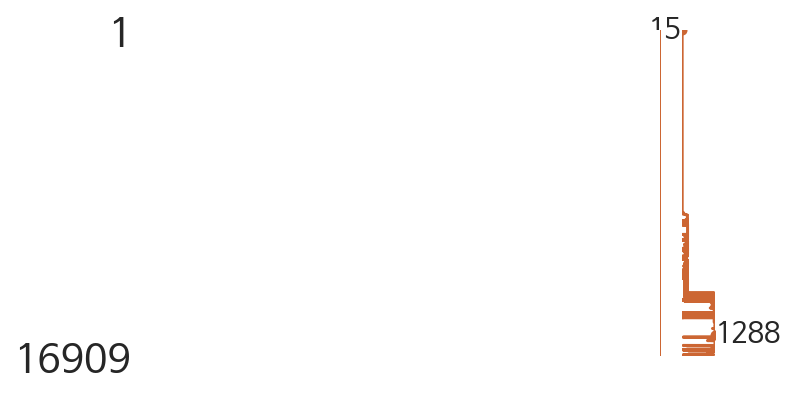

In [0]:
# 열이 너무 많아서 그래프가 씹혀버리긴 하지만, 대충 이런 식으로 생겼을 것이다.(빈칸이 대단하다는 뜻)
msno.matrix(df = train, figsize = (5, 3), color = (0.8, 0.4, 0.2))

In [0]:
# 컬럼 위치가 1부터 1300인 것에는 이유가 있을 것이고, 가까울수록 유사할 것이다. 확인해 보자.
# train.to_csv('a.csv')
# 확인해봤는데 별 의미가 없는 것 같다. 일단 년, 월, 일, 시간 평균을 한 번 찍어보자...

In [0]:
train.index.hour

Int64Index([11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
            ...
            14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
           dtype='int64', name='Time', length=16909)

In [0]:
train['year'] = train.index.year
train['month'] = train.index.month
train['day'] = train.index.day
train['hour'] = train.index.hour
train.head()

,1,2,3,4,6,8,9,11,12,13,14,15,17,19,21,22,23,24,25,27,28,29,33,34,36,38,39,40,45,46,48,49,52,53,54,56,57,58,60,63,...,1465,1466,1467,1468,1469,1470,1471,1472,1473,1474,1475,1476,1477,1478,1479,1480,1481,1482,1483,1484,1485,1486,1487,1488,1489,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499,1500,year,month,day,hour
Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-07-26 11:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016,7,26,11
2016-07-26 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016,7,26,12
2016-07-26 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016,7,26,13
2016-07-26 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016,7,26,14
2016-07-26 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016,7,26,15


## Year check

In [0]:
2016.07.20.~2018.06.30. 의 데이터를 가지고 있다는 것을 항상 기억하자

In [0]:
# 년도별 결측치 까보기(당연히 2017년이 가장 많을 것이다.)
print('전체 대비 2016년 결측치 비율: {}'.format(train[train['year'] == 2016].isnull().sum().sum() / (16909 * 1300) * 100))
print('전체 대비 2017년 결측치 비율: {}'.format(train[train['year'] == 2017].isnull().sum().sum() / (16909 * 1300) * 100))
print('전체 대비 2018년 결측치 비율: {}'.format(train[train['year'] == 2018].isnull().sum().sum() / (16909 * 1300) * 100))

전체 대비 2016년 결측치 비율: 22.016054263319035
전체 대비 2017년 결측치 비율: 48.01924327963715
전체 대비 2018년 결측치 비율: 7.171974870005505


In [0]:
# 해당하는 년도의 결측치 비율만 보기
print('2016년 대비 2016년 결측치 비율: {:.2f}%'.format(train[train['year'] == 2016].isnull().sum().sum() / (train[train['year'] == 2016].notnull().sum().sum() + train[train['year'] == 2016].isnull().sum().sum()) * 100))
print('2017년 대비 2017년 결측치 비율: {:.2f}%'.format(train[train['year'] == 2017].isnull().sum().sum() / (train[train['year'] == 2017].notnull().sum().sum() + train[train['year'] == 2017].isnull().sum().sum()) * 100))
print('2018년 대비 2018년 결측치 비율: {:.2f}%'.format(train[train['year'] == 2018].isnull().sum().sum() / (train[train['year'] == 2018].notnull().sum().sum() + train[train['year'] == 2018].isnull().sum().sum()) * 100))

2016년 대비 2016년 결측치 비율: 97.54%
2017년 대비 2017년 결측치 비율: 92.40%
2018년 대비 2018년 결측치 비율: 27.83%


122217

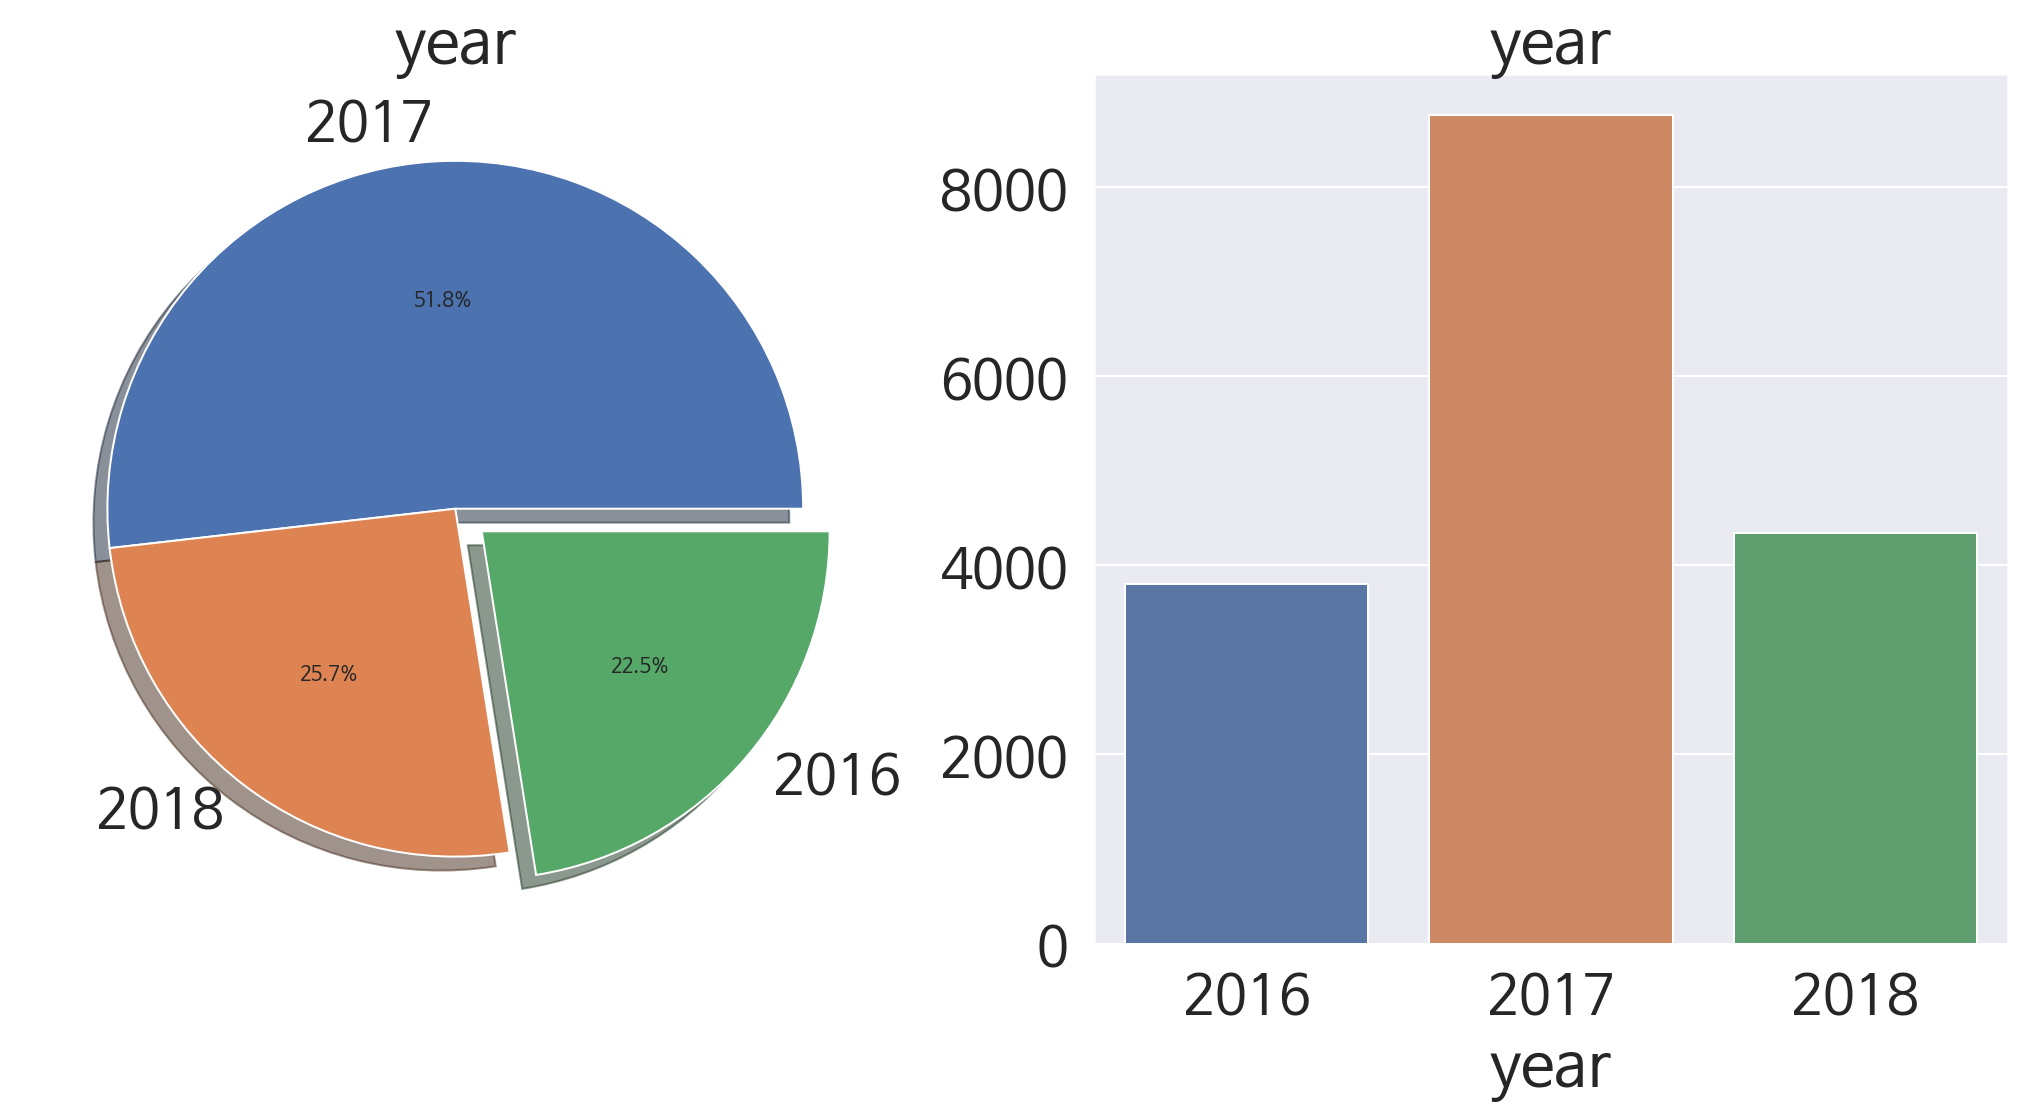

In [0]:
f, ax = plt.subplots(1, 2, figsize = (18, 8)) 
train['year'].value_counts().plot.pie(explode = [0, 0, 0.1], autopct = '%1.1f%%', ax = ax[0], shadow = True)
ax[0].set_title('year')
ax[0].set_ylabel('')
sns.countplot('year', data = train, ax = ax[1])
ax[1].set_title('year')
ax[1].set_ylabel('')
plt.show()